## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

In [14]:
! git clone https://github.com/DS3001/PCA

Cloning into 'PCA'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 12), reused 14 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 2.42 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (12/12), done.


### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
df.head()

,index,Unnamed: 0,Email Text,Email Type
0,0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [3]:
phishing_emails = df[df["Email Type"] == "Phishing Email"].copy()
phishing_emails["tokens"] = phishing_emails["Email Text"].str.split()
phishing_tokens = phishing_emails[["tokens"]]

print(phishing_tokens.head())

                                               tokens
3   [Hello, I, am, your, hot, lil, horny, toy., I,...
4   [software, at, incredibly, low, prices, (, 86,...
7   [entourage, ,, stockmogul, newsletter, ralph, ...
8   [we, owe, you, lots, of, money, dear, applican...
10  [make, her, beg, you, to, give, it, to, her, e...


To clean the data, I would remove any random spaces, make everything lowercase, remove punctuation like commas and periods, and remove very common words like articles that are likely to appear in phishing emails and normal emails. I would then use PCA to choose my desired transformed variables to use in a linear regression. 

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [21]:
# This questions wouldn't work for me. I imported pickle, and tried a lot of other trouble-shooting options, 
# but I couldn't find a way to make the vector load in.

with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

FileNotFoundError: [Errno 2] No such file or directory: 'all_tokens.pickle'

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [7]:
data = pd.read_parquet('/Users/emorywise/Desktop/DS3001 Data/Phishing_clean.parquet')
data.head()

,Email Type,new,date,get,please,enron,like,2002,would,one,...,ï¿½ï¿½,safety,yap,ypil,maintain,procedures,tip,elizabeth,leadership,italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y = data['Email Type']
X = data.drop('Email Type',axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=125)

lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('Train R-squared: ', r2_score(y_hat_train_0,y_train) )
print('Test R-squared: ', r2_score(y_hat_test_0,y_test) )  

Train R-squared:  0.615685210631733
Test R-squared:  -0.00026838432607867446


In [9]:
# Displaying top 5 coefficients
# My output doesn't really seem right to me, so I think I did this wrong but I'm not sure how to correct it

coefficients = lm_0.coef_
features = X.columns

coeff_df = pd.DataFrame({
    "Variable": features,
    "Coefficient": coefficients
})

coeff_df = coeff_df.reindex(coeff_df.Coefficient.abs().sort_values(ascending=False).index)

top_5 = coeff_df.head(5)

print("\nTop 5 Variables with Highest Coefficients:")
print(top_5)


Top 5 Variables with Highest Coefficients:
       Variable   Coefficient
74        2002, -2.450399e+13
6          2002 -2.104031e+13
2224     pudge. -1.745763e+13
2223  1997-2002  1.745763e+13
1014       8859 -1.659539e+13


### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<AxesSubplot:>

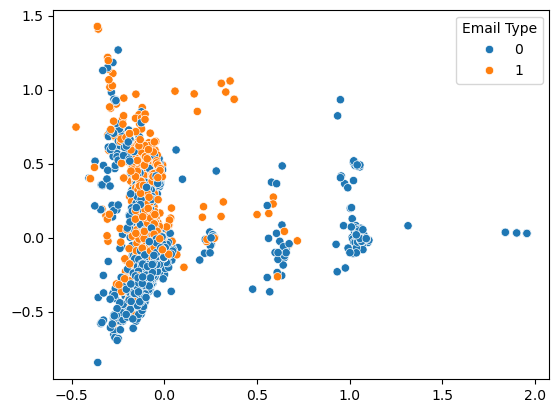

In [16]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The orange dots seem to be far more densely clustered in the second component; only a couple appear in the first component section of the graph.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [20]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train R-squared: ', r2_score(y_hat_train,y_train) )
print('Test R-squared: ', r2_score(y_hat_test,y_test) )    

Train R-squared:  0.6928975360963752
Test R-squared:  0.5873905973217185


### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Since there are so many features in the dataset, a lot of multicollinearity and overfitting is very likely present. PCA eliminates the multicollinearity and reduces overfitting by focusing only on the most important components of the data.